### Import relevant libraries

In [1]:
# import the plotting library and logging library
using PyPlot, Logging
Logging.configure(filename="linear.log", level=DEBUG)

# start all the workers
if length(workers()) > 1; rmprocs(workers()); end
addprocs(12)
# import the relevant libraries for each worker
@everywhere using Optim, PyCall

### Parameters of the simulations

In [2]:
# dimensionality of receptive field and # of neurons
D, M = 4, 40
# range of the # of training trials to simulate
Ps = round(Int64, logspace(log10(D), log10(500), 10))
# nose std with signal std fixed at 1
σn = sqrt(1/2)
# number of trials (sets of receptive fields) and # of test stimulus to decode in each trial
ntrial, ntest = 10, 100;

### Run  simulations

In [16]:
# shared arrays storing simulated decoding errors
# oracle, linear optimal, linear regularized, ML, and MAP
errs_oracle, errs_l_opt, errs_l_reg, errs_ml, errs_map =
    [SharedArray(Float64, length(Ps), ntrial) for k in 1:5]

for (ixP, P) in enumerate(Ps)
    debug("ixP: $ixP") # writes to the log file to track progress
    @sync @parallel for ix in 1:ntrial
        # random receptive fields
        X = randn(M, D) / sqrt(D)
        # training and testing stimuli
        θtrains = qr(randn(D, P)')[1]' * sqrt(P)
        θtest = randn(D, ntest)
        # training and testing response
        rtrains = X * θtrains + randn(M, P) * σn
        rtest = X * θtest + randn(M, ntest) * σn
        # covariance of response
        Σ = θtrains * θtrains' + eye(D) * σn^2 * D
        Σinv = inv(Σ)
        # cross covariance between resp and stimu
        Ρ = θtrains * rtrains'
        
        # oracle decoder
        θ_oracle = inv(X' * X + σn^2 * eye(D)) * X' * rtest
        
        # optimal linear decoder
        Xhat = (inv(Σ) * Ρ)'
        θ_l_opt = inv(Xhat'* Xhat + σn^2 * (1 + trace(Σinv)) * eye(D)) * Xhat' * rtest
                
        # regularized linear decoder using sklearn
        @pyimport sklearn.linear_model as lm
        @pyimport sklearn.cross_validation as cv
        model = lm.MultiTaskElasticNetCV(l1_ratio=1e-9,
            alphas=logspace(-3, 3, 11),
            cv=cv.ShuffleSplit(n=P, test_size=1, n_iter=10))
        model[:fit](rtrains', θtrains')
        θ_l_reg = model[:predict](rtest')'
        
        # posterior variance and mean as function of stimulus
        σ2(θ) = σn^2 * (1 + (θ' * Σinv * θ)[1])
        μ(θ) = vec((θ' * Σinv * θtrains * rtrains')[:])
        # and their gradients
        gσ2(θ) = 2 * σn^2 * Σinv * θ
        gμ(θ) = Σinv * θtrains * rtrains'
        # ML and MAP decoding
        θ_ml, θ_map = zeros(D, ntest), zeros(D, ntest)
        for ixtest in 1:ntest
            # negative log likelihood function
            nll(θ) = (sum((rtest[:, ixtest] - μ(θ)).^2) / σ2(θ) + M * log(σ2(θ))) / 2
            # its gradient
            function gnll!(θ, g::Vector)
                g[:] = (M / σ2(θ) * gσ2(θ) - sum((rtest[:, ixtest] - μ(θ)).^2) / σ2(θ)^2 * gσ2(θ)
                    - 2 * gμ(θ) * (rtest[:, ixtest] - μ(θ)) / σ2(θ))/2
            end
            # regularziated nll for MAP
            reg_nll(θ) = nll(θ) + norm(θ)^2 / 2
            # and its gradient
            function greg_nll!(θ, g::Vector)
                gnll!(θ, g)
                g[:] = g[:] + θ
            end
            # decode
            θ_ml[:, ixtest] = optimize(nll, gnll!, randn(D), method=:cg).minimum
            θ_map[:, ixtest] = optimize(reg_nll, greg_nll!, randn(D), method=:cg).minimum
        end
        
        # compute averaged error
        errs_ml[ixP, ix] = sum((θ_ml - θtest).^2) / ntest
        errs_map[ixP, ix] = sum((θ_map - θtest).^2) / ntest
        errs_l_reg[ixP, ix] = sum((θ_l_reg - θtest).^2) / ntest
        errs_l_opt[ixP, ix] = sum((θ_l_opt - θtest).^2) / ntest
        errs_oracle[ixP, ix] = sum((θ_oracle - θtest).^2) / ntest
    end
end

### Theoretical performances given simulation parameters

In [24]:
# complicated polinomial in the performance expression after integrating over MP distribution
function f(P)
    p, m = P / D, M / D
    snr = 1 / σn^2
    rst = (m - 1)^2 * p^2 * snr^4 + 2 * p * (1 + p) * (1 + m) * snr^3
    rst += (1 + 4 * p + 2 * m * p + p^2) * snr^2 + 2 * (1 + p) * snr + 1
end

# optimal linear decoder's performance
function r2_opt(P)
    p, m = P / D, M / D
    snr = 1 / σn^2
    rst = (m - 1) * p * snr^2 + sqrt(f(P))
    rst = rst / (1 + (1 + p) * snr) + 1
    return 1 - 2 / rst
end

r2_opt (generic function with 1 method)

### Plot the simulation results

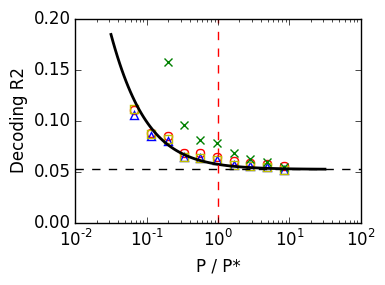

In [23]:
# sufficient number of trials
Pstar = 10 * D * (1 + σn^2)
# optimal linear decoder's theoretical performance
r2_theory = 1 - map(r2_opt, logspace(-1.5, 1.5, 100) * Pstar)
# performance in the inifinite data limit
r2_inf_P = 1 - (1 + σn^2 + M/D - sqrt((1 + σn^2 - M/D)^2 + 4*M/D*σn^2)) / 2

figure(figsize=(4, 3))

# mean simulated decodeing errors for each case
plot(Ps/Pstar, mean(errs_ml, 2) / D, "o", markeredgecolor="r", markerfacecolor="None", markeredgewidth=1)
plot(Ps/Pstar, mean(errs_map, 2) / D, "^", markeredgecolor="b", markerfacecolor="None", markeredgewidth=1)
plot(Ps/Pstar, mean(errs_l_opt, 2) / D, "ys", markeredgecolor="y", markerfacecolor="None", markeredgewidth=1)
plot(Ps/Pstar, mean(errs_l_reg, 2) / D, "cx", markeredgecolor="g", markerfacecolor="None", markeredgewidth=1)
# theoretical prediction of optimal linear decoder
plot(Pss/Pstar, r2_theory, "k-", linewidth=2)
# infinite data limit
PyPlot.axhline(r2_inf_P, linestyle="--", color="k")
# transition at P / P* = 1
PyPlot.axvline(1, linestyle="--", color="r")

ylim([0, 0.2]); xscale("log")
xlabel("P / P*"); ylabel("Decoding R2")
tight_layout()

savefig("M.$(M).snr.$(1/σn^2).eps")